<a href="https://colab.research.google.com/github/jofmorenore/TS_Climatic/blob/main/R/ETL_TS_Climatic.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip3 install matplotlib_scalebar

In [ ]:
!pip3 install rpy2==3.5.1
%load_ext rpy2.ipython

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 201.7/201.7 kB 2.2 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for rpy2: filename=rpy2-3.5.1-cp310-cp310-linux_x86_64.whl size=314931 sha256=9a701a8db1c3c5312a06cb9ab8dc6398b1392a6c040e3ec7a6924dc2671a3d63
  Stored in directory: /root/.cache/pip/wheels/73/a6/ff/4e75dd1ce1cfa2b9a670cbccf6a1e41c553199e9b25f05d953
Successfully built rpy2
  Attempting uninstall: rpy2
    Found existing installation: rpy2 3.4.2
    Uninstalling rpy2-3.4.2:
      Successfully uninstalled rpy2-3.4.2


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import datetime as dt
import matplotlib.colors as colors
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
#import matplotlib.colorbar as colorbar
from matplotlib_venn import venn2
from matplotlib_scalebar.scalebar import ScaleBar
import geopandas as gpd
from geopandas.tools import sjoin
from shapely.geometry.point import Point

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Datos precipitación estaciones meterológicas IDEAM (469 meses x 827 estaciones)

+ Carga los datos de precipitación de las estaciones metereológicas del IDEAM, 846 estaciones con mediciones en 469 columnas correspondientes a los meses

In [ ]:
pcp_col = pd.read_excel('/content/drive/MyDrive/Time_Series_climatic_variebles/pcp_col.xlsx')
print(pcp_col.shape)
pcp_col.head()

(846, 472)


ID          X          Y  1981-01  1981-02  1981-03  1981-04  \
0  17015010 -81.703889  12.586944     71.7     29.1      7.2    170.5   
1  17025020 -81.350000  13.350000     85.6     22.8     31.1    209.3   
2  15015050 -74.228889  11.128333      5.8      0.2      0.7     38.2   
3  14015080 -75.516028  10.447250     16.0      3.6      5.1     54.2   
4  29045190 -74.779778  10.883336      0.0      0.0      1.8     71.7   

   1981-05  1981-06  1981-07  ...  2019-04  2019-05  2019-06  2019-07  \
0    154.1    448.9    194.6  ...     11.7    203.9     91.9     79.0   
1    132.7    638.4    122.6  ...      7.7    300.5     34.8     66.8   
2    112.6     42.0     64.7  ...      0.6     17.3      5.2     32.6   
3    156.2    103.5    178.2  ...      0.2     98.6     60.5     96.8   
4    269.4     35.6     96.3  ...     30.6     78.5     48.7     34.6   

   2019-08  2019-09  2019-10  2019-11  2019-12  2020-01  
0     75.7    144.9    223.0     72.1    136.4    47.83  
1     72.5     83.7    374.7    135.3     92.8   104.90  
2     54.8    120.3    112.3      2.1      0.0     0.00  
3     84.5     67.4    230.5     37.3     13.3     0.00  
4   -999.0    128.6    158.2     97.3      5.4     0.00  

[5 rows x 472 columns]

+ Transforma las columnas de los meses en la fila `Fecha`, y luego pivota las filas de las estaciones en columnas

In [ ]:
# convierte las columnas en filas de 'Fecha', y luego las filas 'ID' en columnas
pcp_col = (pcp_col.melt(id_vars = ['ID', 'X', 'Y'], var_name = 'Fecha', value_name = 'Valor').
           pivot_table('Valor', ['Fecha'], 'ID'))

pcp_col.index = pd.to_datetime(pcp_col.index)
print(pcp_col.index.__class__)
print([pcp_col.shape, min(pcp_col.index), max(pcp_col.index)])

pcp_col.tail(5)

<class 'pandas.core.indexes.datetimes.DatetimeIndex'>
[(469, 846), Timestamp('1981-01-01 00:00:00'), Timestamp('2020-01-01 00:00:00')]


ID          11010010  11020010  11020050  11030010  11030030  11030040  \
Fecha                                                                    
2019-09-01    1326.5    -999.0    -999.0    1291.0    -999.0    -999.0   
2019-10-01     933.1    -999.0    -999.0    -999.0    -999.0    -999.0   
2019-11-01     500.8    -999.0    -999.0    -999.0    -999.0    -999.0   
2019-12-01     831.4    -999.0    -999.0    -999.0    -999.0    -999.0   
2020-01-01     629.1    -999.0    -999.0    -999.0    -999.0    -999.0   

ID          11035010  11035020  11040010  11045010  ...  54020010  54020020  \
Fecha                                               ...                       
2019-09-01    -999.0    -999.0     435.0     721.3  ...    1174.0     528.0   
2019-10-01    -999.0    -999.0     870.0     840.4  ...     758.0    -999.0   
2019-11-01    -999.0    -999.0    -999.0     706.0  ...     798.0    -999.0   
2019-12-01    -999.0    -999.0    -999.0     984.7  ...     963.0    -999.0   
2020-01-01    -999.0    -999.0    -999.0     674.6  ...     560.0    -999.0   

ID          54020040  54020080  54025010  54085010  54090010  55010020  \
Fecha                                                                    
2019-09-01     457.0     643.0     407.4    -999.0     678.0     702.0   
2019-10-01    -999.0     671.0     391.5    -999.0    -999.0    -999.0   
2019-11-01    -999.0    -999.0    -999.0    -999.0    -999.0    -999.0   
2019-12-01    -999.0    -999.0    -999.0    -999.0    -999.0    -999.0   
2020-01-01    -999.0    -999.0     152.5    -999.0    -999.0    -999.0   

ID          55015010  56015010  
Fecha                           
2019-09-01    -999.0     606.0  
2019-10-01    -999.0     834.2  
2019-11-01    -999.0     468.5  
2019-12-01    -999.0     507.6  
2020-01-01    -999.0     331.1  

[5 rows x 846 columns]

## Datos Faltantes

+ 547 (64.7%) estaciones de 846 tienen problemas de datos faltantes, de los cuales:

    + 8 estaciones no cumplen con el C1. Completitud (>90% de los datos), Urrea, V., Ochoa, A., & Mesa, O. (2016)    
    + el C1. Completitud (min de 25 datos en las series de los meses calendario), Pedraza, A. M., & Cuenca, J. S. (2018) lo cumplen todas las series de las estaciones, sin embargo hay 18 estaciones con 3 o más años consecutivos sin datos en 3 o más meses calendario
        + el máximo de faltantes es 10, en 2 estaciones (que no cumplen el C1.>90%) hay 10 eneros faltantes
+ El porcentaje de faltantes varía del 0.02% al 21.9%, con las siguientes participaciones:
    + 1-8 faltantes (64.5% de las 547 estaciones), 8-15 faltantes (23.6%), >15 faltantes (11.9%)

Identificar dónde están ubicadas las estaciones que se remueven? Mostrar todas las estaciones y analizar las que tiene poca calidad

+ Urrea, V., Ochoa, A., & Mesa, O. (2016)

"En total se recopilaron 2716 estaciones de las cuales se seleccionaron aquellas que entre 1981 y 2014 tuvieran más del 90% de los datos obteniendo así un total de 904 estaciones."

+ Pedraza, A. M., & Cuenca, J. S. (2018)

"La selección de las estaciones para la evaluación se realiza bajo la
 verificación de los siguientes criterios:

1. Identificar un mínimo de 25 datos en el periodo 1981 - 2010 (15% de datos
faltantes) en las series de los meses calendario."

Las series de los meses calendario hacen referencia a las series que tienen información solo de un mes específico, por ejemplo: la serie enero contiene la información solo de ese mes en el periodo observado, por lo cual, ellas tienen periodicidad anual, no confundir con las series mensuales cuya periodicidad es mensual. En lo que sigue de este texto se referenciarán como series de los
meses."

"A través de 3 desviaciones estándar (3δ), se examinaron las series de tiempo de los datos para identificar si existían valores atípicos, con ello se buscó identificar si los datos correspondían a: un evento extremo, un evento de variabilidad climática (El Niño/La Niña), un error digital o un error de la estación; de no ser así, se despreció el dato."

+ Arango, C., Dorado, J., Guzmán, D., & Ruiz, J. F. (2012).

"En regiones como el oriente colombiano, se permitieron porcentajes hasta del orden del 65% de la serie, debido a la poca densidad de estaciones y la calidad de las mismas, lo cual no permitió cumplir con lo descrito por la OMM (1989), que establece que las normales climatológicas estándar para un mes de calendario sólo se deben calcular si se dispone de valores de por lo menos 25 de los 30 años, con no más de 2 años consecutivos sin datos."

In [ ]:
def conteo_nulos(col):
    return (col < 0).sum()

df_groupby_nulos = pcp_col.groupby(pcp_col.index.month).apply(conteo_nulos)
print(df_groupby_nulos.max().max()) # el máximo de meses calendario con faltantes es 10
df_groupby_nulos2 = pd.DataFrame({'col': df_groupby_nulos.columns ,'C1': [sum(df_groupby_nulos[i]>=10) for i in df_groupby_nulos.columns]})
max_faltantes = df_groupby_nulos2.loc[df_groupby_nulos2['C1']>0, 'col']
print(df_groupby_nulos[df_groupby_nulos.columns[~df_groupby_nulos.columns.isin(max_faltantes)]].max().max()) # el máx con faltantes es 9, removiendo las 2 estaciones con 10 faltantes
df_groupby_nulos[df_groupby_nulos.columns[df_groupby_nulos.columns.isin(max_faltantes)]]

10
9


ID     21201300  52010020
Fecha                    
1            10        10
2             9         9
3             9         9
4             9         8
5             9         8
6             9         8
7             9         9
8             9         8
9             9         8
10            9         9
11            9         9
12            9         8

In [ ]:
df_nulos = pd.DataFrame({'col': pcp_col.columns,
                         'Nulos' : [pcp_col[i].isna().sum() for i in pcp_col.columns],
                         'Faltantes' : [sum(pcp_col[i]<0) for i in pcp_col.columns]})

print(df_nulos[df_nulos['Nulos']>0].shape[0])
print(df_nulos[df_nulos['Faltantes']>0].shape[0]) # 547 estaciones de 846 tienen problemas de datos faltantes
df_nulos['%Completos'] = 1-(df_nulos['Faltantes']/pcp_col.shape[0])
df_nulos

0
547


col  Nulos  Faltantes  %Completos
0    11010010      0          0    1.000000
1    11020010      0          7    0.985075
2    11020050      0          6    0.987207
3    11030010      0          4    0.991471
4    11030030      0         67    0.857143
..        ...    ...        ...         ...
841  54085010      0         21    0.955224
842  54090010      0          4    0.991471
843  55010020      0          5    0.989339
844  55015010      0         13    0.972281
845  56015010      0          0    1.000000

[846 rows x 4 columns]

In [ ]:
df_nulos['%Completos'].min() # 76.75% es el porcentaje mínimo de datos completos

0.767590618336887

In [ ]:
# 8 estaciones que no cumplen con el C1 de Urrea, V., Ochoa, A., & Mesa, O. (2016)
#estaciones_out = df_nulos.loc[df_nulos['%Completos']<=0.9, 'col']
df_nulos[df_nulos['%Completos']<=0.9]

col  Nulos  Faltantes  %Completos
4    11030030      0         67    0.857143
134  21105030      0         71    0.848614
173  21201300      0        109    0.767591
591  35020350      0         78    0.833689
683  35260050      0         77    0.835821
758  47015070      0         68    0.855011
765  47030020      0         50    0.893390
778  52010020      0        103    0.780384

In [ ]:
def OMM_consecutivo(series):
    # Inicializar un diccionario para almacenar los resultados
    df_ = {'MM': [], 'AAAA_consecutivos': [], 'AAAA': []}

    # Agrupar por mes y calcular los años consecutivos con valores menores a cero
    for mm in range(1, 13):  # Iterar sobre los doce meses
        df_mm = series[series.index.month == mm]
        consecutive_years = 0
        start_year = None

        for year, value in df_mm.items():
            if value < 0:
                if consecutive_years == 0:
                    start_year = year
                consecutive_years += 1
            else:
                consecutive_years = 0
                start_year = None

            # Si hay tres o más años consecutivos, registrar el resultado
            if consecutive_years >= 3:
                df_['MM'].append(mm)
                df_['AAAA_consecutivos'].append(consecutive_years)
                df_['AAAA'].append((start_year, year))
                break
    return df_

def concat_values(series):
    return ','.join(map(str, series))

df_consecutivo = pd.DataFrame()
for i in pcp_col.columns:
  df_ = pd.DataFrame(OMM_consecutivo(pcp_col[i])).agg(concat_values).to_frame().T
  df_['col'] = i
  df_consecutivo = pd.concat([df_consecutivo, df_], axis = 0)

for i in df_consecutivo.columns:
  df_consecutivo[i] = np.where(df_consecutivo[i]=='', None, df_consecutivo[i])

df_consecutivo = df_consecutivo.dropna().reset_index(drop = True)
df_consecutivo['n_meses'] = df_consecutivo['MM'].str.count(',')+1
df_consecutivo

MM        AAAA_consecutivos  \
0         1,2,3,4,5,6,7,8,9,12      3,3,3,3,3,3,3,3,3,3   
1                            5                        3   
2   1,2,3,4,5,6,7,8,9,10,11,12  3,3,3,3,3,3,3,3,3,3,3,3   
3   1,2,3,4,5,6,7,8,9,10,11,12  3,3,3,3,3,3,3,3,3,3,3,3   
4                            9                        3   
5                  1,2,6,11,12                3,3,3,3,3   
6                        6,7,8                    3,3,3   
7                       1,9,12                    3,3,3   
8                            6                        3   
9                   1,10,11,12                  3,3,3,3   
10                           9                        3   
11                   8,9,10,11                  3,3,3,3   
12                           8                        3   
13              1,3,4,5,6,7,12            3,3,3,3,3,3,3   
14  1,2,3,4,5,6,7,8,9,10,11,12  3,3,3,3,3,3,3,3,3,3,3,3   
15               1,3,4,8,10,11              3,3,3,3,3,3   
16                           7                        3   
17               2,3,4,5,6,7,8            3,3,3,3,3,3,3   
18                           8                        3   
19         1,2,3,4,5,6,7,11,12        3,3,3,3,3,3,3,3,3   
20                           1                        3   
21                       6,7,8                    3,3,3   
22              7,8,9,10,11,12              3,3,3,3,3,3   
23                       2,3,6                    3,3,3   
24                          12                        3   
25  1,2,3,4,5,6,7,8,9,10,11,12  3,3,3,3,3,3,3,3,3,3,3,3   
26                           5                        3   
27  1,2,3,4,5,6,7,8,9,10,11,12  3,3,3,3,3,3,3,3,3,3,3,3   

                                                 AAAA       col  n_meses  
0   (Timestamp('2012-01-01 00:00:00'), Timestamp('...  11030030       10  
1   (Timestamp('2012-05-01 00:00:00'), Timestamp('...  16035010        1  
2   (Timestamp('2016-01-01 00:00:00'), Timestamp('...  21105030       12  
3   (Timestamp('2011-01-01 00:00:00'), Timestamp('...  21201300       12  
4   (Timestamp('2017-09-01 00:00:00'), Timestamp('...  21201630        1  
5   (Timestamp('2012-01-01 00:00:00'), Timestamp('...  23190510        5  
6   (Timestamp('2015-06-01 00:00:00'), Timestamp('...  26030050        3  
7   (Timestamp('2017-01-01 00:00:00'), Timestamp('...  26110150        3  
8   (Timestamp('2014-06-01 00:00:00'), Timestamp('...  26145030        1  
9   (Timestamp('2015-01-01 00:00:00'), Timestamp('...  26230240        4  
10  (Timestamp('2017-09-01 00:00:00'), Timestamp('...  32040020        1  
11  (Timestamp('2017-08-01 00:00:00'), Timestamp('...  32047030        4  
12  (Timestamp('2016-08-01 00:00:00'), Timestamp('...  32070030        1  
13  (Timestamp('2018-01-01 00:00:00'), Timestamp('...  32157050        7  
14  (Timestamp('1981-01-01 00:00:00'), Timestamp('...  35020350       12  
15  (Timestamp('2018-01-01 00:00:00'), Timestamp('...  35065010        6  
16  (Timestamp('2013-07-01 00:00:00'), Timestamp('...  35075030        1  
17  (Timestamp('2012-02-01 00:00:00'), Timestamp('...  35180050        7  
18  (Timestamp('2013-08-01 00:00:00'), Timestamp('...  35260010        1  
19  (Timestamp('1981-01-01 00:00:00'), Timestamp('...  35260050        9  
20  (Timestamp('2015-01-01 00:00:00'), Timestamp('...  35267030        1  
21  (Timestamp('2012-06-01 00:00:00'), Timestamp('...  44030060        3  
22  (Timestamp('2011-07-01 00:00:00'), Timestamp('...  44055010        6  
23  (Timestamp('2016-02-01 00:00:00'), Timestamp('...  44140020        3  
24  (Timestamp('2016-12-01 00:00:00'), Timestamp('...  44167020        1  
25  (Timestamp('2012-01-01 00:00:00'), Timestamp('...  47015070       12  
26  (Timestamp('2015-05-01 00:00:00'), Timestamp('...  47030020        1  
27  (Timestamp('1981-01-01 00:00:00'), Timestamp('...  52010020       12

In [ ]:
df_out = df_consecutivo.merge(df_nulos, on =  'col', how  = 'inner').sort_values(by = 'n_meses', ascending = False)
estaciones_out = df_out.loc[(df_out['n_meses']>=3) | (df_out['%Completos']<=0.9), 'col']
estaciones_out

14    35020350
3     21201300
25    47015070
27    52010020
2     21105030
0     11030030
19    35260050
13    32157050
17    35180050
15    35065010
22    44055010
5     23190510
9     26230240
11    32047030
21    44030060
6     26030050
7     26110150
23    44140020
26    47030020
Name: col, dtype: object

In [ ]:
df_nulos.loc[~df_nulos['col'].isin(estaciones_out), '%Completos'].min() # 90.61% es el porcentaje mínimo de datos completos

0.906183368869936

In [ ]:
[df_nulos['Faltantes'][df_nulos['Faltantes']>0].min()/496, df_nulos['Faltantes'].max()/496] # van del 0.02% al 21.9%

[0.0020161290322580645, 0.21975806451612903]

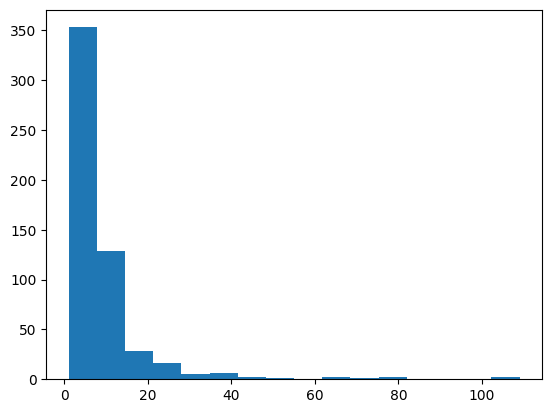

In [ ]:
counts, bins, bars = plt.hist(df_nulos.loc[df_nulos['Faltantes']>0, 'Faltantes'], bins  = 16) #.value_counts()

In [ ]:
df_hist_nulos = pd.DataFrame({'bins': [str(round(bins[i], 0))+'-'+str(round(bins[i+1],0)) for i in range(len(bins[:-1]))], 'counts': counts})
df_hist_nulos['%estaciones_nulos'] = round(df_hist_nulos['counts']/547,3)*100
print(df_hist_nulos['counts'].sum())
df_hist_nulos

547.0


bins  counts  %estaciones_nulos
0       1.0-8.0   353.0               64.5
1      8.0-14.0   129.0               23.6
2     14.0-21.0    28.0                5.1
3     21.0-28.0    16.0                2.9
4     28.0-35.0     5.0                0.9
5     35.0-42.0     6.0                1.1
6     42.0-48.0     2.0                0.4
7     48.0-55.0     1.0                0.2
8     55.0-62.0     0.0                0.0
9     62.0-68.0     2.0                0.4
10    68.0-75.0     1.0                0.2
11    75.0-82.0     2.0                0.4
12    82.0-89.0     0.0                0.0
13    89.0-96.0     0.0                0.0
14   96.0-102.0     0.0                0.0
15  102.0-109.0     2.0                0.4

In [ ]:
pcp_col2 = pd.read_excel('/content/drive/MyDrive/Time_Series_climatic_variebles/pcp_col.xlsx')
pcp_col2['geometry'] = gpd.points_from_xy(pcp_col2['X'], pcp_col2['Y'])
gdf_pcp_col = gpd.GeoDataFrame(pcp_col2[['ID', 'geometry']], geometry='geometry', crs = 'epsg:4326')
gdf_pcp_col.head()

ID                    geometry
0  17015010  POINT (-81.70389 12.58694)
1  17025020  POINT (-81.35000 13.35000)
2  15015050  POINT (-74.22889 11.12833)
3  14015080  POINT (-75.51603 10.44725)
4  29045190  POINT (-74.77978 10.88334)

In [ ]:
# ¿ Dónde están ubicadas las estaciones que se removieron? Están ubicadas en zonas de baja densidad de estaciones?
# https://geoportal.igac.gov.co/contenido/datos-abiertos-cartografia-y-geografia
shp_depto = gpd.read_file('/content/drive/MyDrive/Departamentos202208_shp/Depto.shp')
shp_depto_4326 = shp_depto.to_crs("EPSG:4326")
shp_depto_4326["perimetro"] = shp_depto_4326.boundary

In [ ]:
#outer = sjoin(gdf_pcp_col, shp_depto_4326, how = 'left')
#outer = outer[pd.isna(outer['perimetro'])]
#outer
shp_join_gdf = sjoin(gdf_pcp_col, shp_depto_4326, how = 'left')

In [ ]:
shp_join_gdf.shape

(846, 10)

In [ ]:
outer = shp_join_gdf[shp_join_gdf['ID'].isin(estaciones_out)]
shp_join_gdf.loc[shp_join_gdf['ID'].isin(estaciones_out), 'DeNombre'].value_counts()

DeNombre
Caquetá               3
Cundinamarca          3
Cauca                 2
Huila                 1
Valle del Cauca       1
Vichada               1
Guainía               1
Guaviare              1
Chocó                 1
Putumayo              1
Casanare              1
Norte de Santander    1
Antioquia             1
Name: count, dtype: int64

In [ ]:
# https://stackoverflow.com/questions/58088841/how-to-add-a-north-arrow-on-a-geopandas-map
points = gpd.GeoSeries([Point(-73.5, 40.5), Point(-74.5, 40.5)], crs=4326)  # Geographic WGS 84 - degrees
points = points.to_crs(32619) # Projected WGS 84 - meters
distance_meters = points[0].distance(points[1])
x, y, arrow_length = 0.1, 0.85, 0.1

<Axes: >

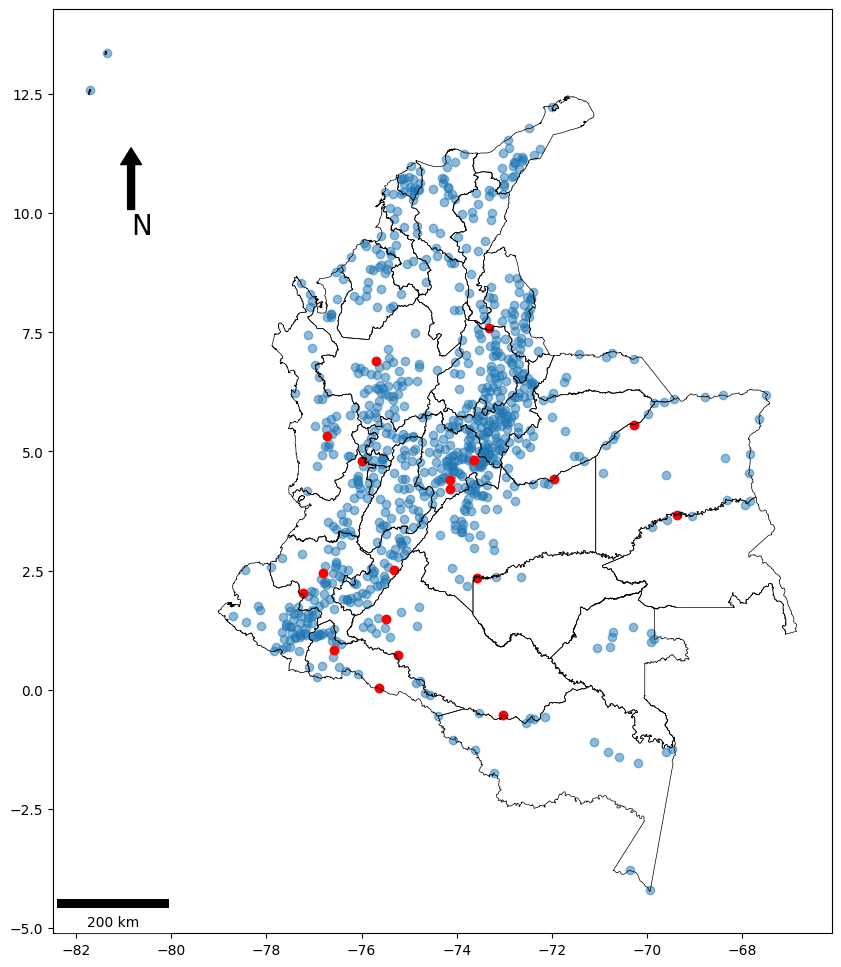

In [ ]:
axis = shp_depto_4326["perimetro"].plot(color = "black",figsize = (20, 12), linewidth = 0.5)
axis.add_artist(ScaleBar(distance_meters, location='lower left'))
axis.annotate('N', xy=(x, y), xytext=(x, y-arrow_length),
              arrowprops=dict(facecolor='black', width=5, headwidth=15),
              ha='left', va='bottom', fontsize=20,
              xycoords=axis.transAxes)
shp_join_gdf.plot(ax = axis, alpha = 0.5, legend = True)
outer.plot(ax = axis, color = 'red')
#outer.plot(ax = axis, column = 'met', cmap=colors.ListedColormap(list(color_dict2.values())))
#outer.plot(ax = axis, column = 'met', alpha = 0.5, cmap=colors.ListedColormap(list(color_dict2.values())))

In [ ]:
outer2 = outer.merge(df_out, left_on = 'ID', right_on = 'col', how = 'inner')
outer2['check'] = np.where(outer2['DeNombre'].isna() | outer2['DeNombre'].isin(['Putumayo', 'Caquetá', 'Guaviare', 'Guainía', 'Vichada', 'Casanare']), 'Y', 'N')
outer2[outer2['check']=='Y'].sort_values(by = '%Completos').reset_index(drop = True)

ID                    geometry  index_right DeCodigo  DeNombre  \
0  35260050   POINT (-70.28064 5.56136)         31.0       99   Vichada   
1  47015070   POINT (-76.57044 0.83897)         25.0       86  Putumayo   
2  47030020   POINT (-75.62972 0.04694)          NaN      NaN       NaN   
3  35180050   POINT (-71.96081 4.41828)         24.0       85  Casanare   
4  32157050   POINT (-69.36056 3.67056)         28.0       94   Guainía   
5  44140020  POINT (-73.03536 -0.52492)          6.0       18   Caquetá   
6  32047030   POINT (-73.58094 2.35467)         29.0       95  Guaviare   
7  44030060   POINT (-75.49325 1.48908)          6.0       18   Caquetá   
8  44055010   POINT (-75.23611 0.73750)          6.0       18   Caquetá   

         DeArea                                 DeNorma    SHAPE_Leng  \
0  99072.891369  Constitución Política de Colombia 1991  1.958906e+06   
1  25701.411410  Constitución Política de Colombia 1991  1.410906e+06   
2           NaN                                     NaN           NaN   
3  44267.044032  Constitución Política de Colombia 1991  1.342606e+06   
4  70918.056082  Constitución Política de Colombia 1991  2.375999e+06   
5  92709.074843  Constitución Política de Colombia 1991  2.352172e+06   
6  55403.198228  Constitución Política de Colombia 1991  2.150051e+06   
7  92709.074843  Constitución Política de Colombia 1991  2.352172e+06   
8  92709.074843  Constitución Política de Colombia 1991  2.352172e+06   

     SHAPE_Area                                          perimetro  \
0  9.907289e+10  LINESTRING (-67.80456 6.29797, -67.80337 6.296...   
1  2.570141e+10  LINESTRING (-76.67233 1.46730, -76.67184 1.467...   
2           NaN                                               None   
3  4.426704e+10  LINESTRING (-72.33885 6.34471, -72.33920 6.344...   
4  7.091806e+10  LINESTRING (-67.71053 4.03842, -67.71041 4.038...   
5  9.270907e+10  LINESTRING (-76.16962 1.58798, -76.16959 1.587...   
6  5.540320e+10  LINESTRING (-71.31266 2.92463, -71.31215 2.924...   
7  9.270907e+10  LINESTRING (-76.16962 1.58798, -76.16959 1.587...   
8  9.270907e+10  LINESTRING (-76.16962 1.58798, -76.16959 1.587...   

                           MM        AAAA_consecutivos  \
0         1,2,3,4,5,6,7,11,12        3,3,3,3,3,3,3,3,3   
1  1,2,3,4,5,6,7,8,9,10,11,12  3,3,3,3,3,3,3,3,3,3,3,3   
2                           5                        3   
3               2,3,4,5,6,7,8            3,3,3,3,3,3,3   
4              1,3,4,5,6,7,12            3,3,3,3,3,3,3   
5                       2,3,6                    3,3,3   
6                   8,9,10,11                  3,3,3,3   
7                       6,7,8                    3,3,3   
8              7,8,9,10,11,12              3,3,3,3,3,3   

                                                AAAA       col  n_meses  \
0  (Timestamp('1981-01-01 00:00:00'), Timestamp('...  35260050        9   
1  (Timestamp('2012-01-01 00:00:00'), Timestamp('...  47015070       12   
2  (Timestamp('2015-05-01 00:00:00'), Timestamp('...  47030020        1   
3  (Timestamp('2012-02-01 00:00:00'), Timestamp('...  35180050        7   
4  (Timestamp('2018-01-01 00:00:00'), Timestamp('...  32157050        7   
5  (Timestamp('2016-02-01 00:00:00'), Timestamp('...  44140020        3   
6  (Timestamp('2017-08-01 00:00:00'), Timestamp('...  32047030        4   
7  (Timestamp('2012-06-01 00:00:00'), Timestamp('...  44030060        3   
8  (Timestamp('2011-07-01 00:00:00'), Timestamp('...  44055010        6   

   Nulos  Faltantes  %Completos check  
0      0         77    0.835821     Y  
1      0         68    0.855011     Y  
2      0         50    0.893390     Y  
3      0         41    0.912580     Y  
4      0         39    0.916844     Y  
5      0         35    0.925373     Y  
6      0         28    0.940299     Y  
7      0         27    0.942431     Y  
8      0         22    0.953092     Y

+ Dejar las estaciones con datos faltantes, al momento de validar los algoritmos de imputación de datos efocar en estas estaciones
+ evaluar de acuerdo al porcentaje de datos faltantes
+ max de estaciones en un radio
+ condicionar el radio de acuerdo a la altitud


In [ ]:
outer2[outer2['check']=='N'].sort_values(by = '%Completos').reset_index(drop = True)

ID                   geometry  index_right DeCodigo  \
0  21201300  POINT (-74.13200 4.39425)         10.0       25   
1  52010020  POINT (-77.22167 2.03278)          7.0       19   
2  35020350  POINT (-74.14686 4.21889)         10.0       25   
3  21105030  POINT (-75.32225 2.52169)         12.0       41   
4  11030030  POINT (-76.72808 5.33419)         11.0       27   
5  35065010  POINT (-73.64647 4.83039)         10.0       25   
6  26230240  POINT (-75.70483 6.90019)          1.0       05   
7  23190510  POINT (-73.32750 7.59556)         16.0       54   
8  26110150  POINT (-75.98650 4.79383)         22.0       76   
9  26030050  POINT (-76.81114 2.45603)          7.0       19   

             DeNombre        DeArea                                 DeNorma  \
0        Cundinamarca  23963.653733  Constitución Política de Colombia 1886   
1               Cauca  30918.668571  Constitución Política de Colombia 1886   
2        Cundinamarca  23963.653733  Constitución Política de Colombia 1886   
3               Huila  18137.066741                      Ley No. 46 de 1905   
4               Chocó  48428.101179                      Ley No. 13 de 1947   
5        Cundinamarca  23963.653733  Constitución Política de Colombia 1886   
6           Antioquia  62786.020507  Constitución Política de Colombia 1886   
7  Norte de Santander  21824.164492                      Ley No. 25 de 1910   
8     Valle del Cauca  20672.170696                 Decreto No. 340 de 1910   
9               Cauca  30918.668571  Constitución Política de Colombia 1886   

     SHAPE_Leng    SHAPE_Area  \
0  1.167148e+06  2.396365e+10   
1  1.551193e+06  3.091867e+10   
2  1.167148e+06  2.396365e+10   
3  1.145831e+06  1.813707e+10   
4  2.286068e+06  4.842810e+10   
5  1.167148e+06  2.396365e+10   
6  2.356259e+06  6.278602e+10   
7  1.199903e+06  2.182417e+10   
8  1.389590e+06  2.067217e+10   
9  1.551193e+06  3.091867e+10   

                                           perimetro  \
0  LINESTRING (-74.32755 5.82396, -74.32716 5.823...   
1  LINESTRING (-76.16981 1.58801, -76.16975 1.587...   
2  LINESTRING (-74.32755 5.82396, -74.32716 5.823...   
3  LINESTRING (-76.16981 1.58801, -76.16994 1.588...   
4  LINESTRING (-77.36821 8.67737, -77.36771 8.676...   
5  LINESTRING (-74.32755 5.82396, -74.32716 5.823...   
6  LINESTRING (-76.41356 8.74766, -76.41269 8.747...   
7  LINESTRING (-72.60285 8.57925, -72.59724 8.572...   
8  LINESTRING (-76.07919 5.04480, -76.07931 5.044...   
9  LINESTRING (-76.16981 1.58801, -76.16975 1.587...   

                           MM        AAAA_consecutivos  \
0  1,2,3,4,5,6,7,8,9,10,11,12  3,3,3,3,3,3,3,3,3,3,3,3   
1  1,2,3,4,5,6,7,8,9,10,11,12  3,3,3,3,3,3,3,3,3,3,3,3   
2  1,2,3,4,5,6,7,8,9,10,11,12  3,3,3,3,3,3,3,3,3,3,3,3   
3  1,2,3,4,5,6,7,8,9,10,11,12  3,3,3,3,3,3,3,3,3,3,3,3   
4        1,2,3,4,5,6,7,8,9,12      3,3,3,3,3,3,3,3,3,3   
5               1,3,4,8,10,11              3,3,3,3,3,3   
6                  1,10,11,12                  3,3,3,3   
7                 1,2,6,11,12                3,3,3,3,3   
8                      1,9,12                    3,3,3   
9                       6,7,8                    3,3,3   

                                                AAAA       col  n_meses  \
0  (Timestamp('2011-01-01 00:00:00'), Timestamp('...  21201300       12   
1  (Timestamp('1981-01-01 00:00:00'), Timestamp('...  52010020       12   
2  (Timestamp('1981-01-01 00:00:00'), Timestamp('...  35020350       12   
3  (Timestamp('2016-01-01 00:00:00'), Timestamp('...  21105030       12   
4  (Timestamp('2012-01-01 00:00:00'), Timestamp('...  11030030       10   
5  (Timestamp('2018-01-01 00:00:00'), Timestamp('...  35065010        6   
6  (Timestamp('2015-01-01 00:00:00'), Timestamp('...  26230240        4   
7  (Timestamp('2012-01-01 00:00:00'), Timestamp('...  23190510        5   
8  (Timestamp('2017-01-01 00:00:00'), Timestamp('...  26110150        3   
9  (Timestamp('2015-06-01 00:00:00'), Timestamp('...  26030050  

In [ ]:
estaciones_out2 = outer2.loc[outer2['check']=='N', 'ID']
estaciones_out2

0     21105030
2     26030050
3     26110150
4     35065010
11    11030030
13    52010020
15    23190510
16    26230240
17    21201300
18    35020350
Name: ID, dtype: object

In [ ]:
print(pcp_col.shape)
pcp_col.head()

(469, 846)


ID          11010010  11020010  11020050  11030010  11030030  11030040  \
Fecha                                                                    
1981-01-01     666.0      42.0     485.0     354.0     807.0     155.0   
1981-02-01     687.0     117.0     688.0     389.0     611.0     380.0   
1981-03-01     545.0     207.0     847.0     193.0     734.0     345.0   
1981-04-01     836.0     330.0     901.0     400.0     773.0     440.0   
1981-05-01     707.0     313.0    1029.0     319.0     546.0     385.0   

ID          11035010  11035020  11040010  11045010  ...  54020010  54020020  \
Fecha                                               ...                       
1981-01-01     671.7     530.2    1356.0     501.2  ...     576.0     483.0   
1981-02-01     643.6     640.6    2035.0     796.3  ...     519.0     573.0   
1981-03-01     514.0     449.1    1722.0     855.9  ...     793.0     622.0   
1981-04-01     852.8     485.5    1990.0     663.1  ...     393.0     785.0   
1981-05-01     669.9     505.8    2492.0     411.4  ...     454.0     567.0   

ID          54020040  54020080  54025010  54085010  54090010  55010020  \
Fecha                                                                    
1981-01-01     146.0     605.0     382.0     385.8     383.0     583.0   
1981-02-01     328.0     618.0     455.7     381.0     276.0     540.0   
1981-03-01     301.0     323.0     223.1     264.8     528.0     587.0   
1981-04-01     340.0     542.0     302.2     620.8     507.0     607.0   
1981-05-01     605.0     588.0     384.8     599.5     562.0     376.0   

ID          55015010  56015010  
Fecha                           
1981-01-01     474.0     456.0  
1981-02-01     551.0     202.2  
1981-03-01     365.0     559.5  
1981-04-01     450.0     366.5  
1981-05-01     421.0     596.4  

[5 rows x 846 columns]

In [ ]:
pcp_col.to_parquet('/content/drive/MyDrive/Time_Series_climatic_variebles/chirps/sttns_pcp_col.parquet')

In [ ]:
pcp_col = pcp_col[pcp_col.columns[~pcp_col.columns.isin(estaciones_out2)]]
print(pcp_col.shape)
pcp_col.head()

(469, 836)


ID          11010010  11020010  11020050  11030010  11030040  11035010  \
Fecha                                                                    
1981-01-01     666.0      42.0     485.0     354.0     155.0     671.7   
1981-02-01     687.0     117.0     688.0     389.0     380.0     643.6   
1981-03-01     545.0     207.0     847.0     193.0     345.0     514.0   
1981-04-01     836.0     330.0     901.0     400.0     440.0     852.8   
1981-05-01     707.0     313.0    1029.0     319.0     385.0     669.9   

ID          11035020  11040010  11045010  11050010  ...  54020010  54020020  \
Fecha                                               ...                       
1981-01-01     530.2    1356.0     501.2     449.0  ...     576.0     483.0   
1981-02-01     640.6    2035.0     796.3     708.0  ...     519.0     573.0   
1981-03-01     449.1    1722.0     855.9     588.0  ...     793.0     622.0   
1981-04-01     485.5    1990.0     663.1     495.0  ...     393.0     785.0   
1981-05-01     505.8    2492.0     411.4     708.0  ...     454.0     567.0   

ID          54020040  54020080  54025010  54085010  54090010  55010020  \
Fecha                                                                    
1981-01-01     146.0     605.0     382.0     385.8     383.0     583.0   
1981-02-01     328.0     618.0     455.7     381.0     276.0     540.0   
1981-03-01     301.0     323.0     223.1     264.8     528.0     587.0   
1981-04-01     340.0     542.0     302.2     620.8     507.0     607.0   
1981-05-01     605.0     588.0     384.8     599.5     562.0     376.0   

ID          55015010  56015010  
Fecha                           
1981-01-01     474.0     456.0  
1981-02-01     551.0     202.2  
1981-03-01     365.0     559.5  
1981-04-01     450.0     366.5  
1981-05-01     421.0     596.4  

[5 rows x 836 columns]

 # Datos CHIRPS


 https://iridl.ldeo.columbia.edu/SOURCES/.UCSB/.CHIRPS/.v2p0/.monthly/.global/.precipitation/

+ representabilidad de los datos, los datos satelitaes representan un area
+ tener en cuenta la altitud para considerar el número de pixeles, a mayor altitud tomar menos pixeles (max 4, min 1)
+ incertidumbre espacial:

In [ ]:
%%R
chirps <- list.files('/content/drive/MyDrive/Time_Series_climatic_variebles/chirps/colombia', full.names = TRUE, pattern = '.tif$')
tail(chirps)

[1] "/content/drive/MyDrive/Time_Series_climatic_variebles/chirps/colombia/chirps-v2.0.2022.07.tif"
[2] "/content/drive/MyDrive/Time_Series_climatic_variebles/chirps/colombia/chirps-v2.0.2022.08.tif"
[3] "/content/drive/MyDrive/Time_Series_climatic_variebles/chirps/colombia/chirps-v2.0.2022.09.tif"
[4] "/content/drive/MyDrive/Time_Series_climatic_variebles/chirps/colombia/chirps-v2.0.2022.10.tif"
[5] "/content/drive/MyDrive/Time_Series_climatic_variebles/chirps/colombia/chirps-v2.0.2022.11.tif"
[6] "/content/drive/MyDrive/Time_Series_climatic_variebles/chirps/colombia/chirps-v2.0.2022.12.tif"


In [ ]:
%%R
if("terra" %in% row.names(installed.packages())==FALSE){suppressMessages(install.packages("terra"))}

In [ ]:
%%R
if("sf" %in% row.names(installed.packages())==FALSE){suppressMessages(install.packages("sf"))}

In [ ]:
%%R
if("arrow" %in% row.names(installed.packages())==FALSE){suppressMessages(install.packages("arrow"))}

In [ ]:
%%R
library(dplyr)
library(lubridate)
library(sf)
library(stringr)
library(terra)
library(arrow)

Attaching package: ‘arrow’



    buffer



    duration



    timestamp




In [ ]:
%%R
chirps <- terra::rast(chirps)
chirps

class       : SpatRaster 
dimensions  : 353, 298, 504  (nrow, ncol, nlyr)
resolution  : 0.05, 0.05  (x, y)
extent      : -81.75, -66.85, -4.250001, 13.4  (xmin, xmax, ymin, ymax)
coord. ref. : lon/lat WGS 84 (EPSG:4326) 
sources     : chirps-v2.0.1981.01.tif  
              chirps-v2.0.1981.02.tif  
              chirps-v2.0.1981.03.tif  
              ... and 501 more source(s)
names       : chirp~81.01, chirp~81.02, chirp~81.03, chirp~81.04, chirp~81.05, chirp~81.06, ... 
min values  :  -9999.0000,  -9999.0000,  -9999.0000,  -9999.0000,   -9999.000,  -9999.0000, ... 
max values  :    677.3947,    795.7532,    752.9749,    944.5653,    1483.174,    934.6393, ... 


In [ ]:
%%R
#--- converting to a data.frame ---#
chirps_df <- as.data.frame(chirps, xy = TRUE) # this works with Raster* objects as well
print(head(chirps_df[,1:5]))
print(paste(rep('.',80), collapse = ''))
print(tail(chirps_df[,c(1,2,505:506)]))

           x      y chirps-v2.0.1981.01 chirps-v2.0.1981.02 chirps-v2.0.1981.03
5067 -81.725 12.525           52.069359            26.44028          15.8991852
5863 -71.725 12.425           11.745375            37.81181           5.3487139
5865 -71.625 12.425            5.190650            20.21614           0.5644872
5866 -71.575 12.425            4.368718            14.71338           0.5129853
5867 -71.525 12.425            5.244236            10.91335           0.3851539
6161 -71.725 12.375            9.055499            42.63746           3.1894126
[1] "................................................................................"
             x         y chirps-v2.0.2022.11 chirps-v2.0.2022.12
104238 -69.975 -4.075001            331.2895            290.4229
104239 -69.925 -4.075001            340.8881            305.4037
104535 -70.025 -4.125001            328.9645            299.4938
104536 -69.975 -4.125001            344.4142            306.3362
104537 -69.925 -4.125001    

In [ ]:
%%R
write_parquet(chirps_df, sink = '/content/drive/MyDrive/Time_Series_climatic_variebles/chirps/chirps_df.parquet')

In [ ]:
CHIRPS = pd.read_table('/content/drive/MyDrive/Time_Series_climatic_variebles/chirps/Chirps_MetStationsCol_1981_2022.csv', sep = ';')
print(CHIRPS.shape)
CHIRPS.head()

(856, 507)


X            Y chirps-v2.0.1981.01 chirps-v2.0.1981.02  \
0  -81,70388889  12,58694444    52,0693588256836    26,4402809143066   
1        -81,35        13,35    52,0693588256836    26,4402809143066   
2  -74,22888889  11,12833333     6,6460108757019    7,19210004806519   
3  -75,51602778     10,44725    2,81759476661682    3,90068984031677   
4  -74,77977778  10,88333611    3,24257707595825    3,43615508079529   

  chirps-v2.0.1981.03 chirps-v2.0.1981.04 chirps-v2.0.1981.05  \
0    15,8991851806641     29,680965423584    118,903198242188   
1    15,8991851806641     29,680965423584    118,903198242188   
2      31,07177734375    241,704162597656    246,043792724609   
3    3,21060681343079     61,374195098877    162,358047485352   
4     10,976634979248    95,3337783813477    189,924880981445   

  chirps-v2.0.1981.06 chirps-v2.0.1981.07 chirps-v2.0.1981.08  ...  \
0    407,559356689453    152,137405395508     216,55436706543  ...   
1    407,559356689453    152,137405395508     216,55436706543  ...   
2    164,090484619141    217,608154296875    262,416748046875  ...   
3    136,302368164062         113,1484375     144,16259765625  ...   
4    86,1386566162109    59,3365097045898    135,806198120117  ...   

  chirps-v2.0.2022.04 chirps-v2.0.2022.05 chirps-v2.0.2022.06  \
0    37,5365905761719    246,244445800781    438,563110351562   
1    37,5365905761719    246,244445800781    438,563110351562   
2    114,056434631348    143,296997070312     321,63427734375   
3    78,1036758422852    85,1550445556641    204,286560058594   
4    101,241180419922    137,911178588867    225,750289916992   

  chirps-v2.0.2022.07 chirps-v2.0.2022.08 chirps-v2.0.2022.09  \
0    152,714828491211    283,285888671875    125,137817382812   
1    152,714828491211    283,285888671875    125,137817382812   
2    109,550476074219    255,035064697266    338,348754882812   
3    149,545959472656    127,331008911133     163,36848449707   
4    65,4175338745117    167,021438598633    259,239898681641   

  chirps-v2.0.2022.10 chirps-v2.0.2022.11 chirps-v2.0.2022.12  \
0    236,296859741211     392,38232421875    52,2510070800781   
1    236,296859741211     392,38232421875    52,2510070800781   
2    299,917785644531    261,644439697266    11,7831754684448   
3    291,169403076172    226,575622558594    9,60346221923828   
4    412,114959716797    225,212661743164    3,31930589675903   

                                 geometry  
0   c(-81.7249985355884, 12.524999441579)  
1   c(-81.7249985355884, 12.524999441579)  
2  c(-74.2249984238297, 11.1249994207174)  
3  c(-75.5249984432012, 10.4249994102865)  
4  c(-74.7749984320253, 10.8749994169921)  

[5 rows x 507 columns]

In [ ]:
for i in CHIRPS.columns[:-1]:
  CHIRPS[i] = pd.to_numeric(CHIRPS[i].str.replace(',', '.'), errors = 'coerce')

In [ ]:
CHIRPS.head()

X          Y  chirps-v2.0.1981.01  chirps-v2.0.1981.02  \
0 -81.703889  12.586944            52.069359            26.440281   
1 -81.350000  13.350000            52.069359            26.440281   
2 -74.228889  11.128333             6.646011             7.192100   
3 -75.516028  10.447250             2.817595             3.900690   
4 -74.779778  10.883336             3.242577             3.436155   

   chirps-v2.0.1981.03  chirps-v2.0.1981.04  chirps-v2.0.1981.05  \
0            15.899185            29.680965           118.903198   
1            15.899185            29.680965           118.903198   
2            31.071777           241.704163           246.043793   
3             3.210607            61.374195           162.358047   
4            10.976635            95.333778           189.924881   

   chirps-v2.0.1981.06  chirps-v2.0.1981.07  chirps-v2.0.1981.08  ...  \
0           407.559357           152.137405           216.554367  ...   
1           407.559357           152.137405           216.554367  ...   
2           164.090485           217.608154           262.416748  ...   
3           136.302368           113.148438           144.162598  ...   
4            86.138657            59.336510           135.806198  ...   

   chirps-v2.0.2022.04  chirps-v2.0.2022.05  chirps-v2.0.2022.06  \
0            37.536591           246.244446           438.563110   
1            37.536591           246.244446           438.563110   
2           114.056435           143.296997           321.634277   
3            78.103676            85.155045           204.286560   
4           101.241180           137.911179           225.750290   

   chirps-v2.0.2022.07  chirps-v2.0.2022.08  chirps-v2.0.2022.09  \
0           152.714828           283.285889           125.137817   
1           152.714828           283.285889           125.137817   
2           109.550476           255.035065           338.348755   
3           149.545959           127.331009           163.368484   
4            65.417534           167.021439           259.239899   

   chirps-v2.0.2022.10  chirps-v2.0.2022.11  chirps-v2.0.2022.12  \
0           236.296860           392.382324            52.251007   
1           236.296860           392.382324            52.251007   
2           299.917786           261.644440            11.783175   
3           291.169403           226.575623             9.603462   
4           412.114960           225.212662             3.319306   

                                 geometry  
0   c(-81.7249985355884, 12.524999441579)  
1   c(-81.7249985355884, 12.524999441579)  
2  c(-74.2249984238297, 11.1249994207174)  
3  c(-75.5249984432012, 10.4249994102865)  
4  c(-74.7749984320253, 10.8749994169921)  

[5 rows x 507 columns]

In [ ]:
[[i, CHIRPS[i].isna().sum()]for i in CHIRPS.columns]

[['X', 0],
 ['Y', 0],
 ['chirps-v2.0.1981.01', 0],
 ['chirps-v2.0.1981.02', 0],
 ['chirps-v2.0.1981.03', 0],
 ['chirps-v2.0.1981.04', 0],
 ['chirps-v2.0.1981.05', 0],
 ['chirps-v2.0.1981.06', 0],
 ['chirps-v2.0.1981.07', 0],
 ['chirps-v2.0.1981.08', 0],
 ['chirps-v2.0.1981.09', 0],
 ['chirps-v2.0.1981.10', 0],
 ['chirps-v2.0.1981.11', 0],
 ['chirps-v2.0.1981.12', 0],
 ['chirps-v2.0.1982.01', 0],
 ['chirps-v2.0.1982.02', 0],
 ['chirps-v2.0.1982.03', 0],
 ['chirps-v2.0.1982.04', 0],
 ['chirps-v2.0.1982.05', 0],
 ['chirps-v2.0.1982.06', 0],
 ['chirps-v2.0.1982.07', 0],
 ['chirps-v2.0.1982.08', 0],
 ['chirps-v2.0.1982.09', 0],
 ['chirps-v2.0.1982.10', 0],
 ['chirps-v2.0.1982.11', 0],
 ['chirps-v2.0.1982.12', 0],
 ['chirps-v2.0.1983.01', 0],
 ['chirps-v2.0.1983.02', 0],
 ['chirps-v2.0.1983.03', 0],
 ['chirps-v2.0.1983.04', 0],
 ['chirps-v2.0.1983.05', 0],
 ['chirps-v2.0.1983.06', 0],
 ['chirps-v2.0.1983.07', 0],
 ['chirps-v2.0.1983.08', 0],
 ['chirps-v2.0.1983.09', 0],
 ['chirps-v2.0.1983.1

## Razón de los valores normales